In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, NNConv
from tqdm import tqdm
import torch.optim as optim
import json
import pprint

In [2]:
from helper_function_module import init_setup
seed = 1234
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.5.1+cu121
- CUDA Version: 12.1
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


# Importing the Main tabular data

In [3]:
with open('json_data/signal_btag_label.json', 'r') as file:
    signal = json.load(file)

with open('json_data/background_btag_label.json', 'r') as file:
    background = json.load(file)

In [4]:
pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 119966
Example:
{'edge_index': [[0], [1]],
 'edges': [3.554905509698394],
 'event_label': 1,
 'eventno': 155069,
 'inv_mass': 119.30746642984421,
 'jet_btag_label': [0.0, 0.0],
 'jetmultiplicity': 2,
 'node_labels': [1, 1],
 'nodes': [[1.64501, 1.48088, 37.6831, 101.256],
           [-0.804118, -1.09577, 28.2866, 37.9352]]}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Background Event: 126444
Example:
{'edge_index': [[0], [1]],
 'edges': [2.687206180843956],
 'event_label': 0,
 'eventno': 229615,
 'inv_mass': 36.52110596182952,
 'jet_btag_label': [0.0, 1.0],
 'jetmultiplicity': 1,
 'node_labels': [0, 1],
 'nodes': [[0.0530316, -0.146326, 10.9979, 11.0134],
           [-0.373657, -2.79944, 30.6956, 32.8635]]}


# Converting Each Event into a PyG Graph Object

In [5]:
def convert_to_pyg_graph(graph):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass' for a single event.
    label : int
        The label of the event (1 for signal, 0 for background).

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)  # Shape: (num_jets, num_features)
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.float).view(-1,1)
    jet_btag_labels = torch.tensor(graph['jet_btag_label'], dtype=torch.float).view(-1,1)
    
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['jetmultiplicity'],
                                         graph['inv_mass'],
                                         np.array(graph['edges']).std(),
                                        graph['node_labels'].count(0),
                                        graph['jet_btag_label'].count(1)], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.eventno = event_num
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    data.count_isophoton = graph_level_features[0, 3]
    data.count_btag_jets = graph_level_features[0, 4]
    data.node_label = node_labels 
    data.jet_btag_label = jet_btag_labels

    return data

def convert_all_to_pyg_graphs(graphs):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completely successfully :)')
    return pyg_graphs

In [6]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal)
background_pyg_graphs = convert_all_to_pyg_graphs(background)

Initializing the process...


Progress:   0%|          | 0/119966 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Progress: 100%|██████████| 119966/119966 [00:17<00:00, 6877.44it/s]


Process completely successfully :)
Initializing the process...


Progress: 100%|██████████| 126444/126444 [00:19<00:00, 6556.32it/s]

Process completely successfully :)


In [7]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    num_nodes = data.x.size()[0]
    # Taking only those graph which have one isolated photon and  two btagged jets
    if (num_nodes == 3) & (data.count_isophoton.item() == 1) & (data.count_btag_jets.item() == 2):
        feat = data.x
        nodeFeature_EtaPhiE = torch.cat((feat[:, :2], feat[:,-1].view(-1,1)), dim = 1)
        data.x = nodeFeature_EtaPhiE
        dataset.append(data)

In [8]:
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 2075 samples


In [9]:
print("Example Graph Data Object:")
print(dataset[2000])

Example Graph Data Object:
Data(x=[3, 3], edge_index=[2, 3], edge_attr=[3, 1], y=0, eventno=146907, jet_multiplicity=2.0, inv_mass=98.00668334960938, proximity_spread=0.9354212284088135, count_isophoton=1.0, count_btag_jets=2.0, node_label=[3, 1], jet_btag_label=[3, 1])


In [10]:
print(dataset[2000].eventno)

tensor(146907)


In [11]:
dataset[2000].node_label

tensor([[0.],
        [1.],
        [1.]])

In [12]:
dataset[2000].edge_attr

tensor([[2.5718],
        [0.8771],
        [3.0599]])

In [13]:
feat = dataset[2000].x
print(feat)

tensor([[-1.4487, -0.5840, 22.9426],
        [-0.6522, -3.0293, 63.8487],
        [-1.1227,  0.2303, 54.8835]])


# Train-Test Splits

In [14]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [15]:
len(train_loader)

21

# Graph Visualization

In [16]:
from helper_function_module import visualize_graph
# visualize_graph(dataset[54], save_fig = False, save_fig_path = 'eventGraph.png')

## Model

In [67]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features,*, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )

            self.graph_features_nn = torch.nn.Sequential(
                torch.nn.Linear(num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, num_hidden_graph_features)
            )
        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )


        ############### Model 4 - Best
        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 64),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, 128),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
             torch.nn.Linear(128, hidden_dim * hidden_dim)
        )
        
        self.conv1 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        # self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # self.conv3 = CGConv((hidden_dim, hidden_dim), aggr = 'max')
        # self.conv4 = GMMConv(hidden_dim, hidden_dim, dim=1, kernel_size=5)
        # self.conv5 = GatedGraphConv(hidden_dim, 5, aggr = 'max')
        self.global_mean_pool_hook = global_mean_pool
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = F.relu(self.conv2(x, edge_index, edge_attr))
        # x = F.relu(self.conv3(x, edge_index, edge_attr))
        # x = F.relu(self.conv4(x, edge_index, edge_attr))
        # x = F.relu(self.conv5(x, edge_index, 1/edge_attr))
        
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)

        graph_features = torch.cat([data.inv_mass.view(-1, 1), data.proximity_spread.view(-1, 1)], dim=1)
        x = torch.cat([x, self.graph_features_nn(graph_features)], dim=1)
        self.graph_embedding = x
        # Fully connected layers
        x = self.classify(x) 

        return torch.sigmoid(x)


## Network Training

In [76]:
from helper_function_module import train, test
model = GCNClassifier(num_node_features=3,
                      num_edge_features = 1,
                      hidden_dim=10,
                      num_graph_features=2,
                      num_hidden_graph_features = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad = False)
criterion = torch.nn.BCELoss().to(device)

EPOCHS = 250
training_loss = []
test_accuracy = []
torch.cuda.empty_cache()

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader, device, optimizer, criterion)
        acc = test(model, test_loader, device, optimizer, criterion)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [01:12<00:00,  3.44it/s, Loss=0.5310, Accuracy=0.7592]


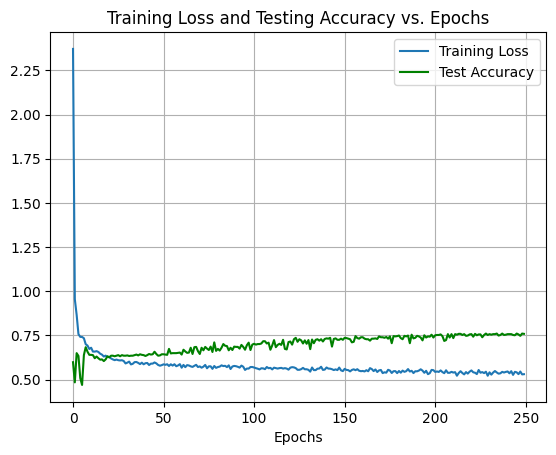

In [77]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Training Loss and Testing Accuracy vs. Epochs')
plt.xlabel('Epochs')
# plt.ylim([0,2])
plt.grid(which = 'both')
# plt.savefig('NNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()

# Testing the Model Performance on Test Data

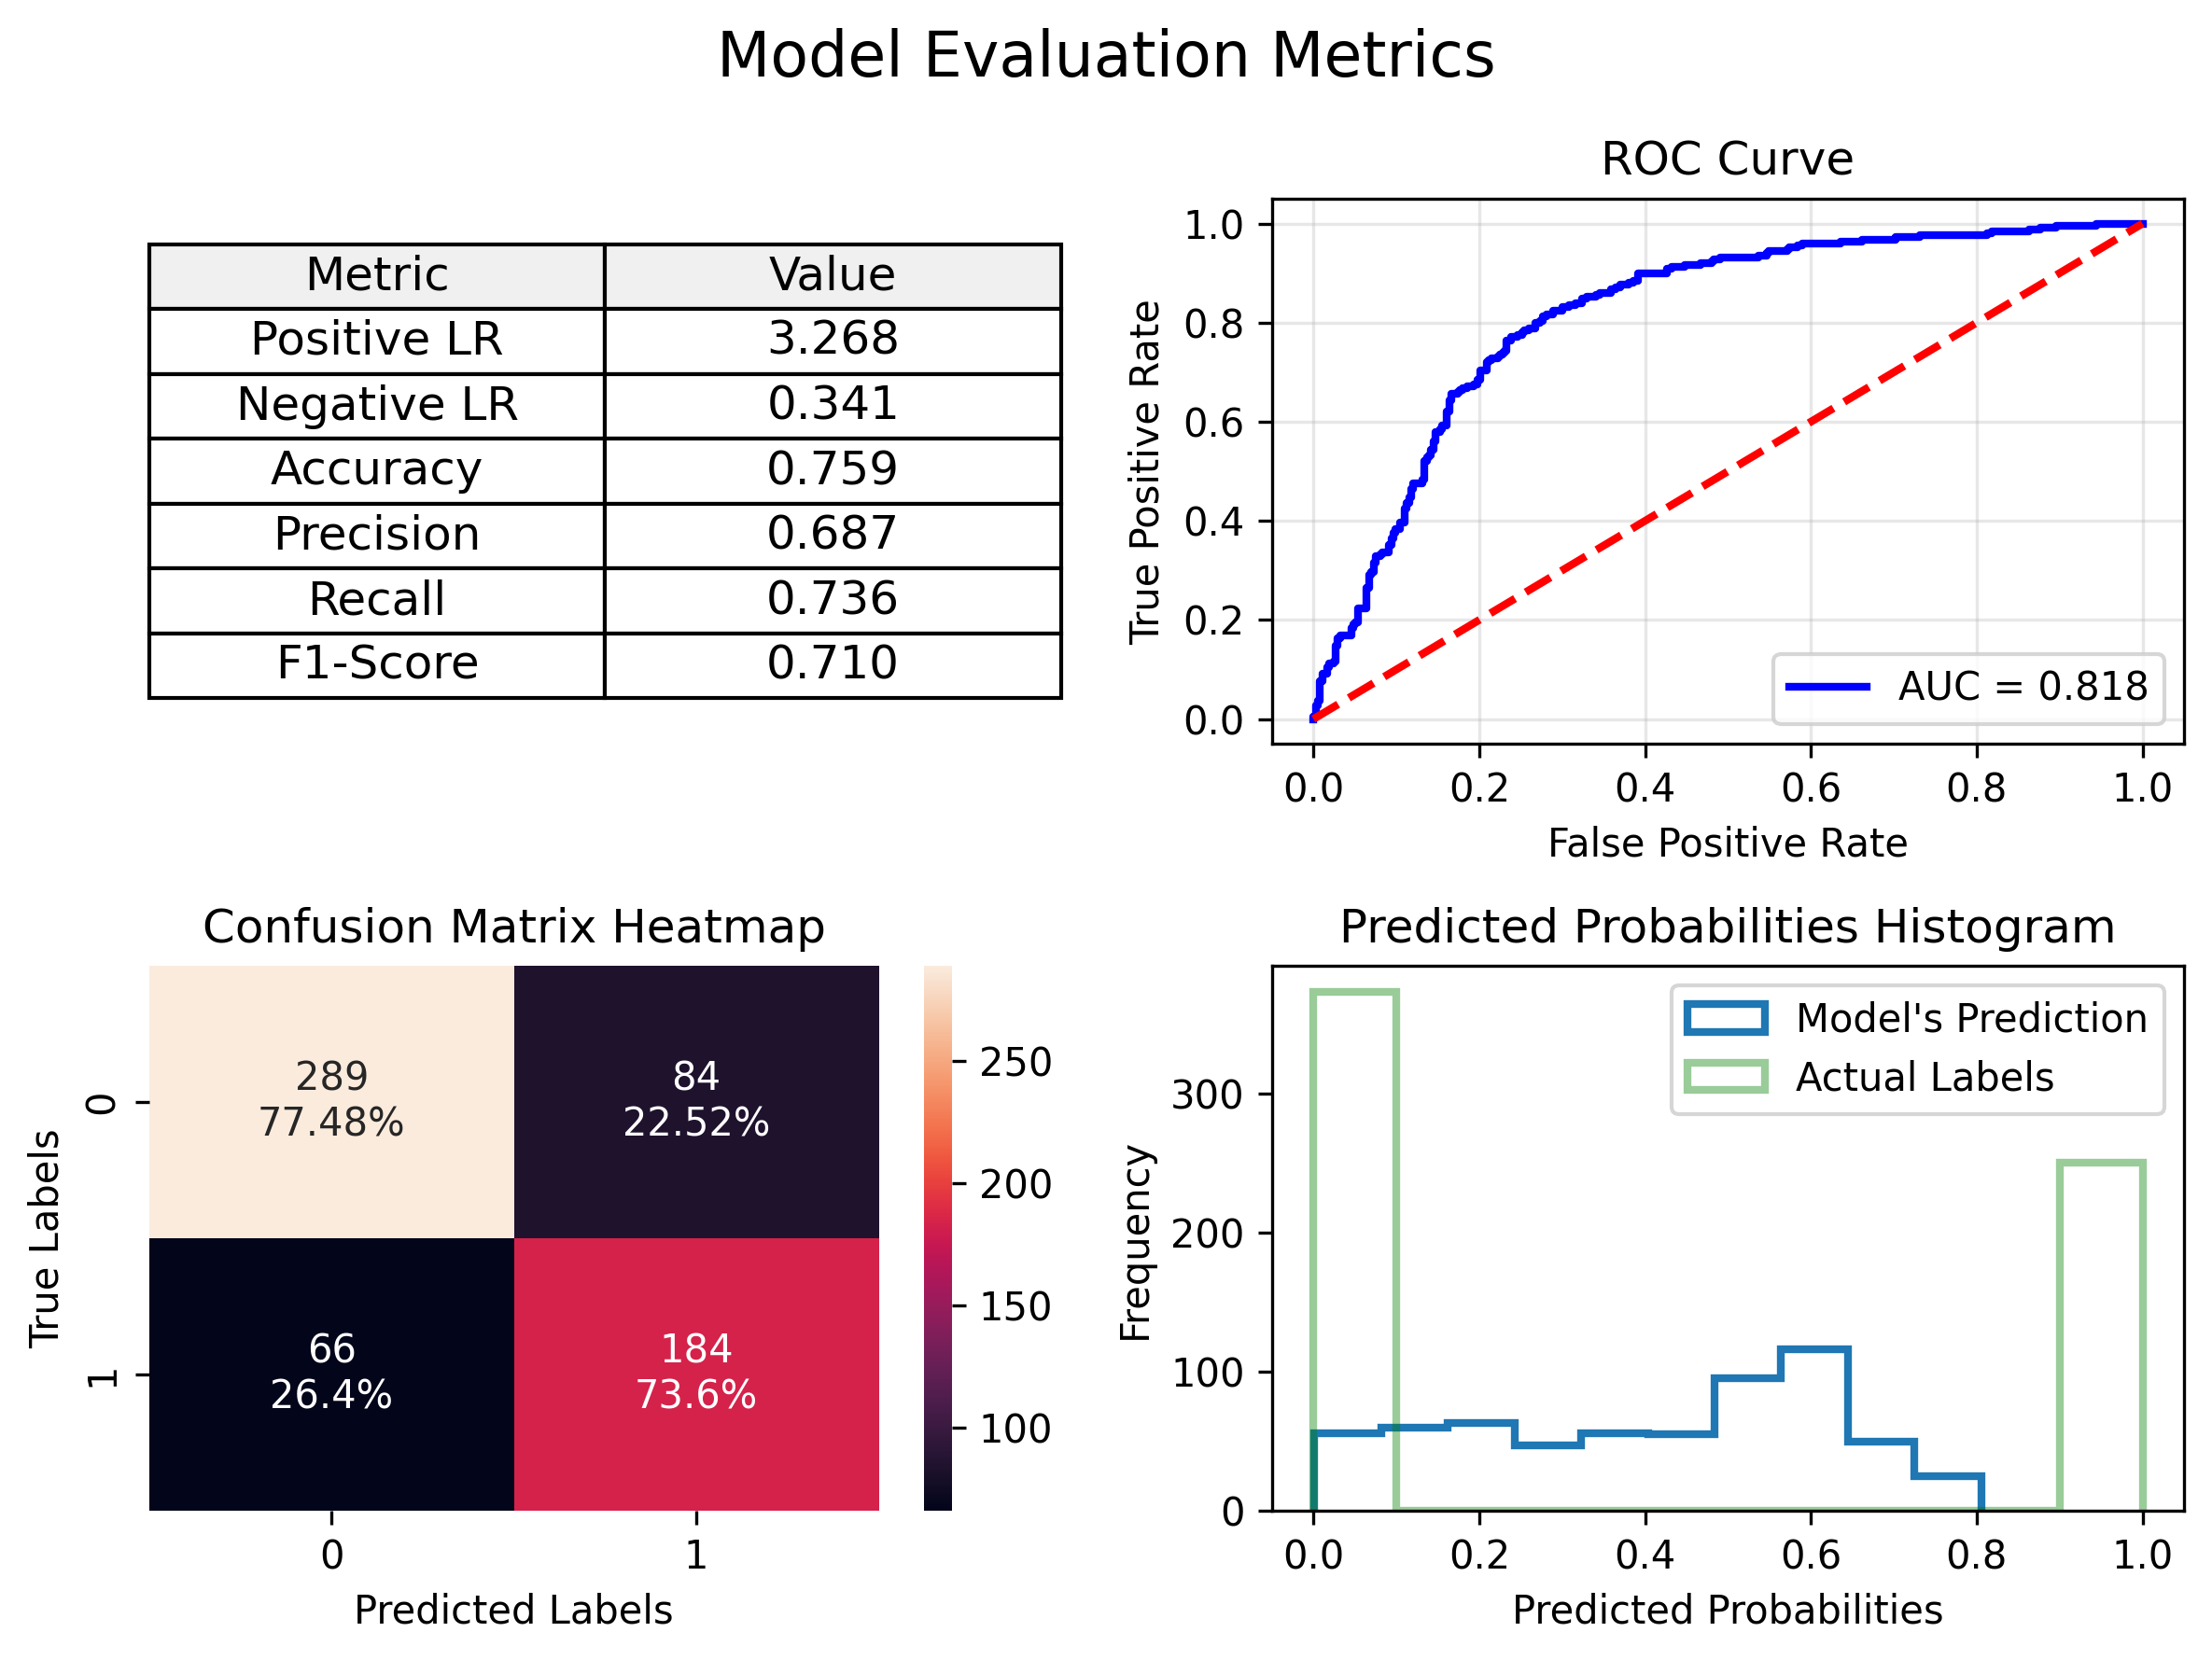

In [78]:
from helper_function_module import eval_model, get_labels_from_model
y_test_true, y_test_pred_prob, y_test_pred_labels = get_labels_from_model(model, test_dataset)
eval_model(y_test_true, y_test_pred_prob, y_test_pred_labels, save_fig = False, save_fig_path = 'NNConvMetricPlot.png')

In [79]:
np.save('./model_output_arrays/NNConv/NNConv_hd10_withProximitySpread_graphNN_EtaPhiE', np.vstack((y_test_true, y_test_pred_prob)))

In [49]:
from collections import Counter
Counter(y_test_true)

Counter({0.0: 373, 1.0: 250})

In [ ]:
# Evaluation Metrics for the Full dataset(train+test)
y_true, y_pred_prob, y_pred_labels = get_labels_from_model(model, dataset)
eval_model(y_true, y_pred_prob, y_pred_labels, save_fig = False, save_fig_path = 'NNConvMetricPlot.png')

In [20]:
from collections import Counter
Counter(y_true)

Counter({0.0: 1271, 1.0: 804})

In [22]:
# np.save('NNConv_main_model', np.vstack((y_true, y_pred_prob)))
# torch.save(model, 'NNConv_main_model.pth')

# Extracting Graph Embedding from the Model

In [23]:
from helper_function_module import get_graph_embeddings
embedding_df = get_graph_embeddings(model, dataset)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Classifying the Graph Embeddings Using a Random Forest Model from these graph embeddings

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [25]:
X, y = embedding_df.iloc[:,:-2].values, embedding_df.iloc[:,-2].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [26]:
param_grid_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_forest = GridSearchCV(RandomForestClassifier(random_state=seed),
                          param_grid=param_grid_forest,
                          cv=5,
                          n_jobs=-1)
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

Best Model Test Accuracy: 0.85
Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200}
ROC AUC: 0.90


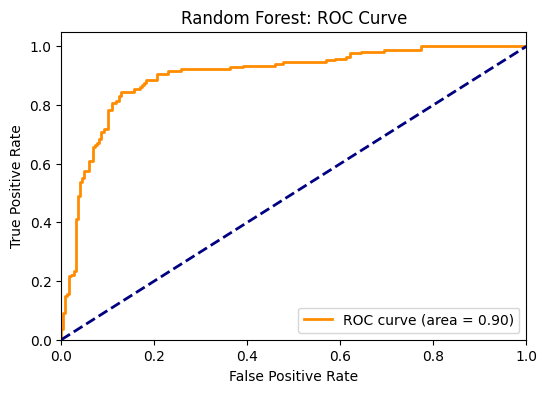

In [27]:
best_model = grid_search_forest.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Test Accuracy: {accuracy:.2f}')
print(f'Best Hyperparameters: {grid_search_forest.best_params_}')

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: ROC Curve')
plt.legend(loc="lower right")
plt.show()

## ANN Based Classifier

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [31]:
input_size = X.shape[1]
model_ANN = Sequential([
    Input((input_size,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_ANN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train the model
history = model_ANN.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, verbose=1)

2025-01-31 18:13:27.873291: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 0.5380 - Precision: 0.4298 - Recall: 0.4152 - accuracy: 0.5563 - loss: 4.7061 - val_AUC: 0.7866 - val_Precision: 0.4369 - val_Recall: 0.9922 - val_accuracy: 0.5000 - val_loss: 0.7271
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - AUC: 0.6023 - Precision: 0.5094 - Recall: 0.4752 - accuracy: 0.5964 - loss: 1.5446 - val_AUC: 0.5000 - val_Precision: 0.3886 - val_Recall: 1.0000 - val_accuracy: 0.3886 - val_loss: 0.6933
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.6297 - Precision: 0.4897 - Recall: 0.4674 - accuracy: 0.6050 - loss: 0.7779 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6114 - val_loss: 0.6931
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5589 - Precision: 0.4943 - Recall: 0.1152 - accuracy: 0.6134 - loss: 0.7110 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.6114 - val_loss: 0.6923
Epoch 5/40
21/21 ━━━━━━

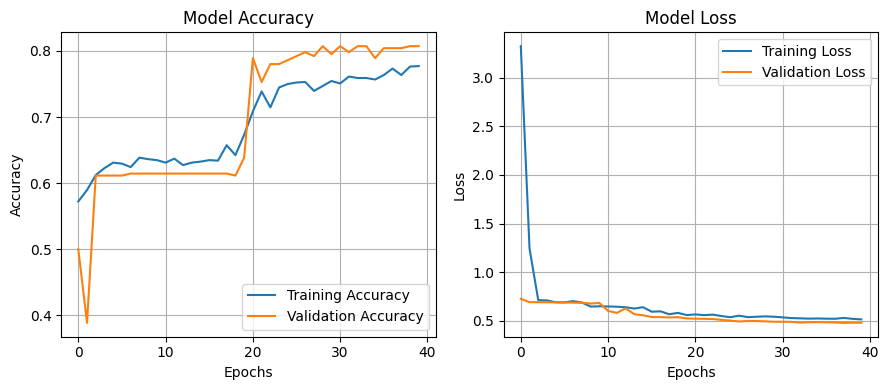

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8876 - Precision: 0.7997 - Recall: 0.7107 - accuracy: 0.8103 - loss: 0.4475 
Test Loss: 0.4616, Test Accuracy: 0.8072, Precision: 0.7806, Recall: 0.7246, AUC: 0.8724
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Example probabilities: [[0.5545724 ]
 [0.09312938]
 [0.7297609 ]
 [0.6057712 ]
 [0.11865522]]
Precision: 0.7806, Recall: 0.7246, F1 Score: 0.7516, ROC AUC: 0.8724


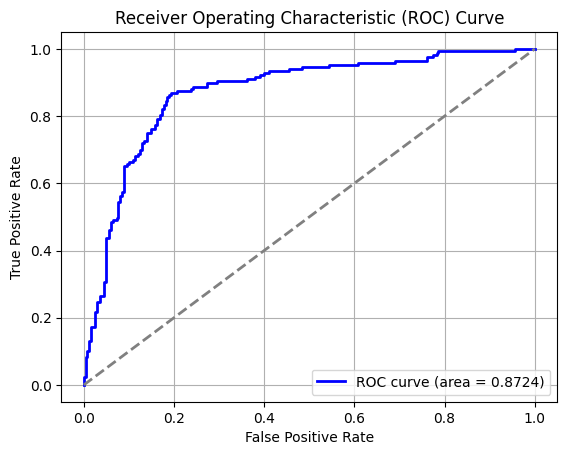

In [32]:
# Plotting training history
plt.figure(figsize=(9, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
evaluation_results = model_ANN.evaluate(X_test, y_test)
loss, accuracy, precision, recall, auc = evaluation_results
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")

# Predict probabilities for the test set
probability_scores = model_ANN.predict(X_test)
print("Example probabilities:", probability_scores[:5])

# Additional evaluation metrics
predictions = (probability_scores > 0.5).astype(int)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probability_scores)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probability_scores)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()